# Loan Status Prediction model

## Project Overview
The goal of this project is to develop a **machine learning model** to predict whether a loan will be **approved** or **denied** based on various factors. 
Additionally, the project aims to determine whether **log-transformed data** produces better results compared to the original data by analyzing and comparing the model's performance with both data types.

## Objectives
- Analyze historical loan data to uncover trends and patterns.
- Identify key factors contributing to **loan approval** or **default**.
- Build a **predictive model** to forecast loan outcomes (approved or denied).
- Compare model performance to **choose the best model** for accurate loan prediction.
- Evaluate the impact of using **log-transformed data** versus original data on model accuracy.
- Test the model with **new data** to determine if a loan will be **approved or denied**.
- Determine **feature Importance** for the selected model.

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


### read the loan dataset

In [2]:
data=pd.read_csv('loan_prediction.csv')
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


### Data Cleaning

#### check the information of the dataset
The dataset has 13 columns with 614 rows. There appears to be null values that need to be cleaned. 

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


#### Let's check the sum of the missing values in our columns

In [4]:
data.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

#### Fill in the missing values with the most frequent value in the column.
This method replaces missing values in a column with the most frequent value (mode) in that column. We use the mode because these columns (like Gender, Married, Self_Employed, etc.) likely represent categorical variables, where the most common category is a reasonable guess for filling in missing data. It helps prevent issues with missing values in the dataset while preserving the overall distribution of the data.

In [5]:
data['Gender']= data['Gender'].fillna(data['Gender'].mode()[0])
data['Married']= data['Married'].fillna(data['Married'].mode()[0])
data['Self_Employed']= data['Self_Employed'].fillna(data['Self_Employed'].mode()[0])
data['Dependents']= data['Dependents'].fillna(data['Dependents'].mode()[0])
data['Loan_Amount_Term']= data['Loan_Amount_Term'].fillna(data['Loan_Amount_Term'].mode()[0])
data['Credit_History']= data['Credit_History'].fillna(data['Credit_History'].mode()[0])


In [6]:
data.head(1)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y


### Fill in the missing values in our LoanAmount column with the average value of the column
We fill missing values in a loan column with the average to provide a good estimate for the missing data. The average represents the typical value in the column, helping to keep the overall data consistent and preventing gaps from affecting the analysis.

In [7]:
data['LoanAmount']= data['LoanAmount'].fillna(data['LoanAmount'].mean())

There are no more missing data in our dataset



In [8]:
data.isnull().any()

Loan_ID              False
Gender               False
Married              False
Dependents           False
Education            False
Self_Employed        False
ApplicantIncome      False
CoapplicantIncome    False
LoanAmount           False
Loan_Amount_Term     False
Credit_History       False
Property_Area        False
Loan_Status          False
dtype: bool

#### Lets's check for duplicates
There are no duplicates

In [9]:
data.duplicated().any()

False

### Data Exploration 

For my model creation, I plan to use both the original data distribution and the log-transformed version of the data. This will allow me to compare model performance under different transformations. By applying the log transformation, I can reduce the impact of outliers and stabilize variance, which may lead to better results if the data is skewed or follows an exponential pattern. Comparing both approaches will help me determine which transformation yields more accurate and robust predictions for my model.

#### Let's check the distribution of the LoanAmount column and the TotalIncome column which is (ApplicantIncome + CoapplicantIncome)

<Axes: >

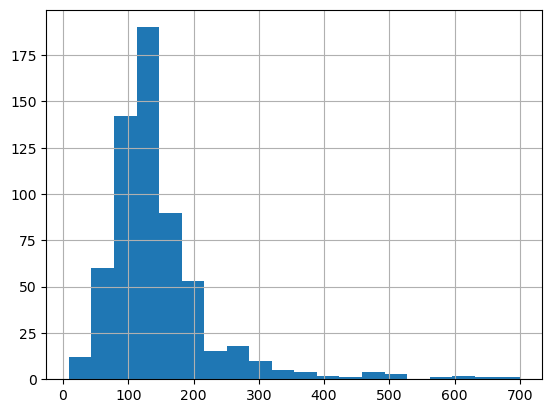

In [10]:
data['LoanAmount'].hist(bins=20)

Observation: The loan column is rightly skewed. This indicates that the data is concentrated on the left side (lower values), with a long tail extending to the right (higher values). This means that most of the data points are smaller and clustered towards lower values, while a few higher outliers pull the tail to the right.i.e. Many small loans and a a few large ones

##### Let's transform the LoanAmount column. 
This process is called log transformation, where we take the natural logarithm of the LoanAmount column in the dataset. This helps reduce skewness and stabilize variance, especially for larger values. The histogram we create afterward shows the distribution of the log-transformed loan amounts, helping us see if this change has made the data more normally distributed, which can improve model performance and make the data easier to understand.

<Axes: >

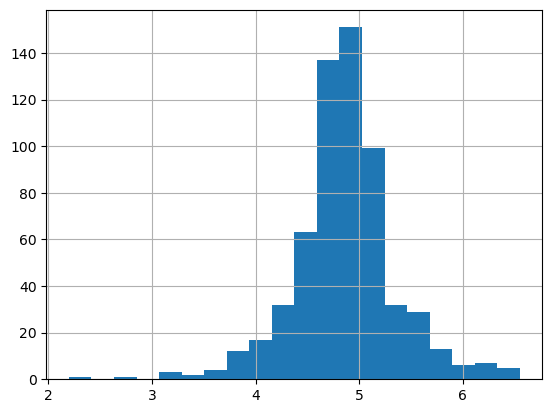

In [11]:
data['LoanAmount_log']=np.log(data['LoanAmount'])
data['LoanAmount_log'].hist(bins=20)

##### let's create the TotalIncome column and check its distribution

<Axes: >

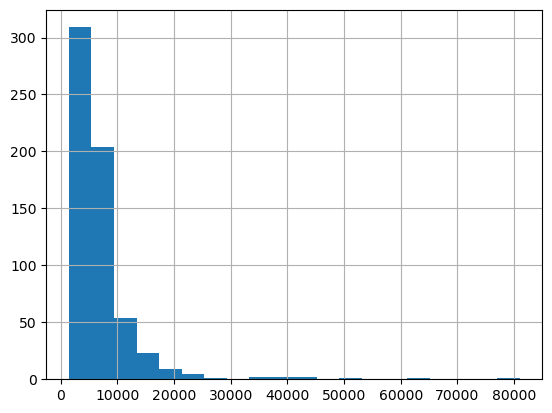

In [12]:
data['TotalIncome'] = data['ApplicantIncome'] + data['CoapplicantIncome'] # create the TotalIncome column
data['TotalIncome'].hist(bins=20) #check the distribution through a histogram

Observation: The loan column is rightly skewed. This indicates that the data is concentrated on the left side (lower values), with a long tail extending to the right (higher values). This means that most of the data points are smaller and clustered towards lower values, while a few higher outliers pull the tail to the right.i.e. Many people have income ranging from 0 to 20000 and a few from 20000 to 80000.

##### Let's transform the LoanAmount column and create a new column, TotalIncome_log.

<Axes: >

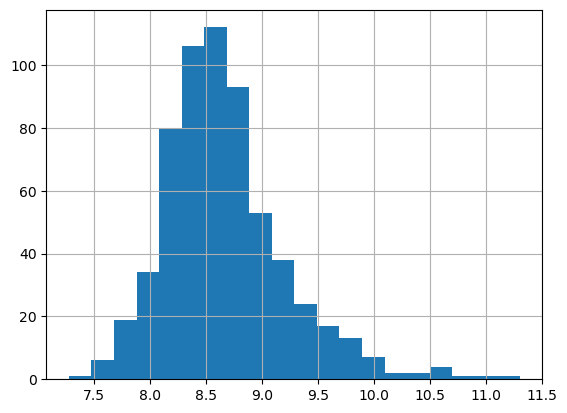

In [13]:
data['TotalIncome_log']=np.log(data['TotalIncome'])
data['TotalIncome_log'].hist(bins=20)

In [14]:
data.columns # checking the columns in our dataset

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status',
       'LoanAmount_log', 'TotalIncome', 'TotalIncome_log'],
      dtype='object')

Number of people who ask for loans, grouped by gender:
Gender
Male      502
Female    112
Name: count, dtype: int64


<Axes: xlabel='Gender', ylabel='count'>

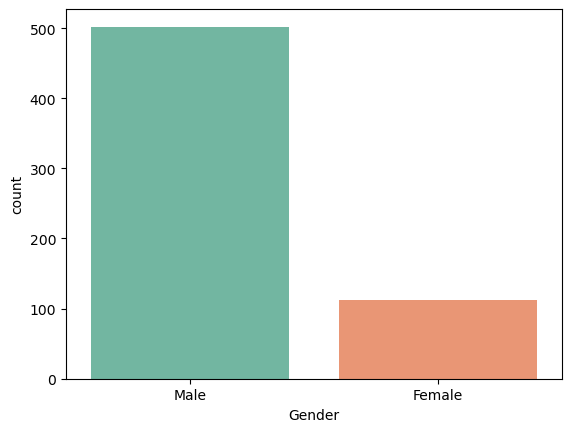

In [15]:
print('Number of people who ask for loans, grouped by gender:')
print(data['Gender'].value_counts())
sns.countplot(x='Gender', data=data, palette='Set2')

Observation: More males tend to ask for loans compared to females.

Number of people who ask for loans, grouped by Marital status:
Married
Yes    401
No     213
Name: count, dtype: int64


<Axes: xlabel='Married', ylabel='count'>

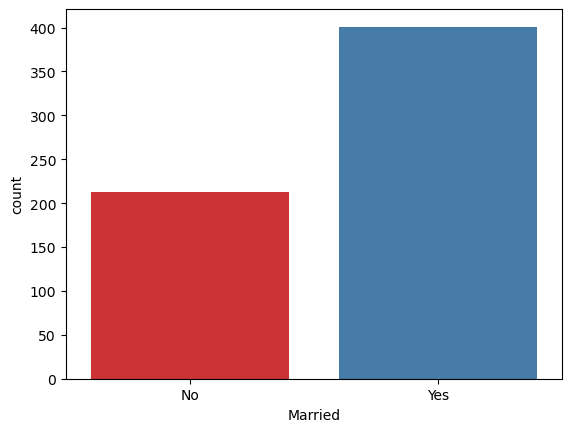

In [16]:
print('Number of people who ask for loans, grouped by Marital status:')
print(data['Married'].value_counts())
sns.countplot(x='Married', data=data, palette='Set1')

Observation: Married individuals tend to apply for loans more often than single people, nearly twice as much. This might be because they have more financial responsibilities, like supporting a family or managing household expenses.

Number of people who ask for loans, grouped by Dependents:
Dependents
0     360
1     102
2     101
3+     51
Name: count, dtype: int64


<Axes: xlabel='Dependents', ylabel='count'>

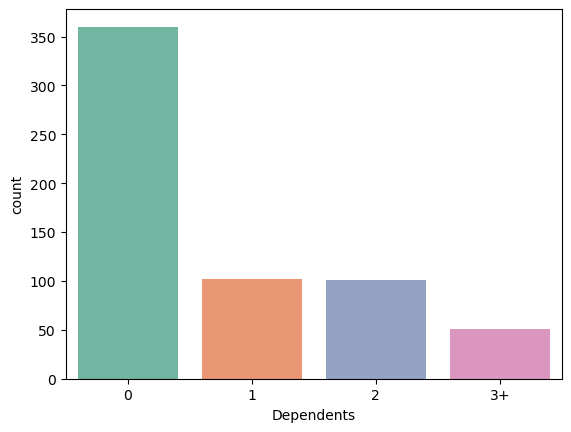

In [17]:
print('Number of people who ask for loans, grouped by Dependents:')
print(data['Dependents'].value_counts())
sns.countplot(x='Dependents', data=data, palette='Set2')

observation: People with less dependants ask for more loans. This may be because they often have fewer financial obligations, allowing them to take on additional debt more comfortably. With less financial responsibility for others, they might feel more secure in their ability to repay loans.

In [18]:
data['Dependents']=data['Dependents'].replace(to_replace='3+', value='4') # replace the 3+ with 4 

Number of people who ask for loans, grouped by Self_Employed:
Self_Employed
No     532
Yes     82
Name: count, dtype: int64


<Axes: xlabel='Self_Employed', ylabel='count'>

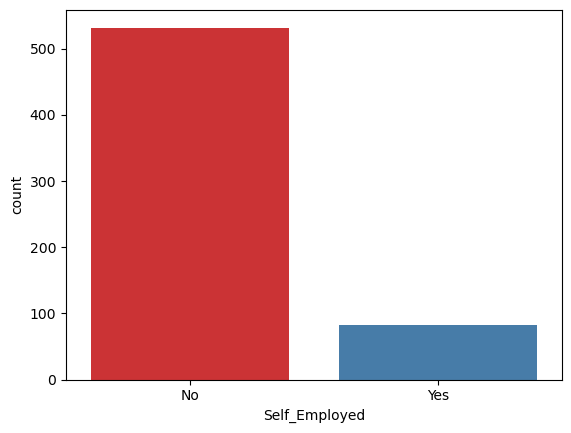

In [19]:
print('Number of people who ask for loans, grouped by Self_Employed:')
print(data['Self_Employed'].value_counts())
sns.countplot(x='Self_Employed', data=data, palette='Set1')

Observation : Fewer self-employed individuals are asking for loans, likely due to the overall lower number of people who are self-employed compared to those in traditional employment. 

Number of people who ask for loans, grouped by LoanAmount:
LoanAmount
146.412162    22
120.000000    20
110.000000    17
100.000000    15
160.000000    12
              ..
240.000000     1
214.000000     1
59.000000      1
166.000000     1
253.000000     1
Name: count, Length: 204, dtype: int64


<Axes: xlabel='LoanAmount', ylabel='count'>

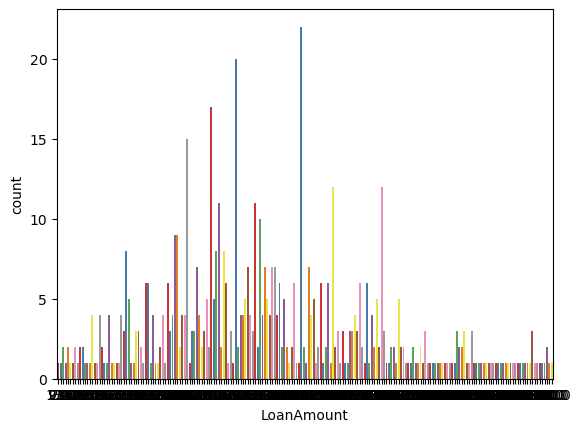

In [20]:
print('Number of people who ask for loans, grouped by LoanAmount:')
print(data['LoanAmount'].value_counts())
sns.countplot(x='LoanAmount', data=data, palette='Set1')

Number of people who ask for loans, grouped by Credit_History:
Credit_History
1.0    525
0.0     89
Name: count, dtype: int64


<Axes: xlabel='Credit_History', ylabel='count'>

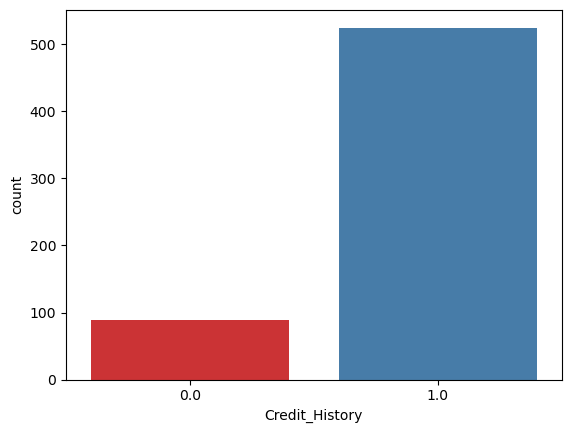

In [21]:
print('Number of people who ask for loans, grouped by Credit_History:')
print(data['Credit_History'].value_counts())
sns.countplot(x='Credit_History', data=data, palette='Set1')

### Let's create our loan prediction model
This loan prediction model will evaluate factors like income, employment status, and credit history to predict whether a loan applicant is likely to be approved and able to repay the loan. By analyzing the data, the model will help lenders make better decisions, reduce risk, and speed up the loan approval process, ensuring that borrowers get the financial support they need.

In [22]:
label_encoder= LabelEncoder() # let's convert our categorical data into numerical values.

In [23]:
# List of columns to encode
columns_to_encode = ['Gender','Married', 'Education', 'Self_Employed', 'Loan_Status', 'Property_Area']  # Add the column names you want to encode

# Apply LabelEncoder to each column
for column in columns_to_encode:
    data[column] = label_encoder.fit_transform(data[column])


In [24]:
data.head(5) # lets checkout our transformesd dataset

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,LoanAmount_log,TotalIncome,TotalIncome_log
0,LP001002,1,0,0,0,0,5849,0.0,146.412162,360.0,1.0,2,1,4.986426,5849.0,8.674026
1,LP001003,1,1,1,0,0,4583,1508.0,128.000000,360.0,1.0,0,0,4.852030,6091.0,8.714568
2,LP001005,1,1,0,0,1,3000,0.0,66.000000,360.0,1.0,2,1,4.189655,3000.0,8.006368
3,LP001006,1,1,0,1,0,2583,2358.0,120.000000,360.0,1.0,2,1,4.787492,4941.0,8.505323
4,LP001008,1,0,0,0,0,6000,0.0,141.000000,360.0,1.0,2,1,4.948760,6000.0,8.699515


## Let's test the model performance using the original dataset without the log transformation

Define a list of feature columns that will be used as input for the model

In [25]:
features=['Gender', 'Married', 'Dependents', 'Education','Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area']

Define our independent variables (features) and the dependent variable (target) as follows:

In [26]:
# Create the feature matrix X using the specified columns from the dataset
X = data[features] 
# Create the target vector y, which contains the loan status (approved or not)
y = data['Loan_Status']  # This variable will be used to train the model to predict loan approval

In [27]:
X = data[features].copy()  # Create a copy of the selected features

The StandardScaler() is used to standardize the features by scaling them to have a mean of 0 and a standard deviation of 1. This is important because it helps ensure that all features contribute equally to the distance calculations in machine learning algorithms, preventing features with larger ranges from disproportionately influencing the model's performance. This method will be applied on ApplicantIncome, CoapplicantIncome, LoanAmount and Loan_Amount_Term columns.

In [28]:
scaler=StandardScaler()

In [29]:
cols =['ApplicantIncome', 'CoapplicantIncome','LoanAmount','Loan_Amount_Term']

In [30]:
X[cols]=scaler.fit_transform(X[cols]) # scale the columns

In [31]:
X.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,1,0,0,0,0,0.072991,-0.554487,0.000000,0.273231,1.0,2
1,1,1,1,0,0,-0.134412,-0.038732,-0.219273,0.273231,1.0,0
2,1,1,0,0,1,-0.393747,-0.554487,-0.957641,0.273231,1.0,2
3,1,1,0,1,0,-0.462062,0.251980,-0.314547,0.273231,1.0,2
4,1,0,0,0,0,0.097728,-0.554487,-0.064454,0.273231,1.0,2


#### We analyzed these models to find the best three to help us improve our predictions about loan approvals.

1. Random Forest: Uses many decision trees together to make better predictions and avoid mistakes. It’s good for predicting if a loan will be approved.

2. Linear Regression: A straightforward model that shows how different factors affect loan approval. It’s easy to understand and helps us compare with other models.

3. Support Vector Classifier (SVC): This model finds the best way to separate approved and denied loans, even when the data is complex.

4. Decision Tree Classifier: A simple model that makes decisions based on rules, showing clearly how it reaches its conclusions about loan approvals.

5. Gradient Boosting Classifier: This model improves its predictions step by step, making it very accurate for predicting loan outcomes.










In [32]:
# Initialize an empty dictionary to store model performance results
model_df = {}
# Function to evaluate the model's performance
def model_val(model, X, y):
    # Split the dataset into training and testing sets, with 20% of the data used for testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit the model using the training data
    model.fit(X_train, y_train)
    
    # Predict the outcomes for the test set
    y_pred = model.predict(X_test)

    # Print the accuracy of the model on the test set
    print(f"{model} accuracy is {accuracy_score(y_test, y_pred)}")

    # Perform cross-validation to evaluate model performance
    score = cross_val_score(model, X, y, cv=5)
    
    # Print the average cross-validation score
    print(f"{model} Avg cross val score is {np.mean(score)}")

    # Store the average cross-validation score in the model_df dictionary
    model_df[model] = round(np.mean(score) * 100, 2)


In [33]:
model_df

{}

#### Random Forest Classifier model

In [34]:
model=RandomForestClassifier()
model_val(model,X,y)

RandomForestClassifier() accuracy is 0.7723577235772358
RandomForestClassifier() Avg cross val score is 0.7850459816073571


#### Linear Regression

In [35]:
model = LogisticRegression()
model_val(model,X,y)

LogisticRegression() accuracy is 0.7886178861788617
LogisticRegression() Avg cross val score is 0.8045715047314408


#### Support Vector Classifier (SVC)

In [36]:
model =svm.SVC()
model_val(model,X,y)

SVC() accuracy is 0.7804878048780488
SVC() Avg cross val score is 0.7964147674263627


#### Decision Tree Classifier

In [37]:
model = DecisionTreeClassifier()
model_val(model,X,y)

DecisionTreeClassifier() accuracy is 0.6910569105691057
DecisionTreeClassifier() Avg cross val score is 0.7133679861388778


#### Gradient Boosting Classifier

In [38]:
model=GradientBoostingClassifier()
model_val(model,X,y)

GradientBoostingClassifier() accuracy is 0.7479674796747967
GradientBoostingClassifier() Avg cross val score is 0.7801146208183394


Observation: The models with the best cross validation scores ( using the original data) are Logistic Regression with a sore of 80.46, Random Forest Classifier with 78.34,
and SVC with a score of 79.64.

## Let's test the model performance using the log transformed data

We will repeat the whole process from selecting our features to testing the performance of our selected models 

In [39]:
features=['Gender', 'Married', 'Dependents', 'Education','Self_Employed','LoanAmount_log','TotalIncome_log',
          'Loan_Amount_Term', 'Credit_History', 'Property_Area']
# replace 'ApplicantIncome', 'CoapplicantIncome' and'LoanAmount' columns with 'LoanAmount_log'and'TotalIncome_log'.

In [40]:
# Create the feature matrix X using the specified columns from the dataset
X2 = data[features] 
# Create the target vector y, which contains the loan status (approved or not)
y = data['Loan_Status']  # This variable will be used to train the model to predict loan approval

In [41]:
X2 = data[features].copy()  # Create a copy of the selected features

In [42]:
scaler=StandardScaler()

In [43]:
cols=['LoanAmount_log','TotalIncome_log','Loan_Amount_Term']

In [44]:
X2[cols]=scaler.fit_transform(X2[cols])

In [45]:
X2.head(2)

,Gender,Married,Dependents,Education,Self_Employed,LoanAmount_log,TotalIncome_log,Loan_Amount_Term,Credit_History,Property_Area
0,1,0,0,0,0,0.250640,0.008468,0.273231,1.0,2
1,1,1,1,0,0,-0.020226,0.082903,0.273231,1.0,0


In [46]:
# Initialize an empty dictionary to store model performance results
model_df2 = {}

# Function to evaluate the model's performance
def model_val(model, X2, y):
    # Split the dataset into training and testing sets, with 20% of the data used for testing
    X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)

    # Fit the model using the training data
    model.fit(X_train, y_train)
    
    # Predict the outcomes for the test set
    y_pred = model.predict(X_test)

    # Print the accuracy of the model on the test set
    print(f"{model} accuracy is {accuracy_score(y_test, y_pred)}")

    # Perform cross-validation to evaluate model performance
    score = cross_val_score(model, X2, y, cv=5)
    
    # Print the average cross-validation score
    print(f"{model} Avg cross val score is {np.mean(score)}")

    # Store the average cross-validation score in the model_df dictionary
    model_df2[model] = round(np.mean(score) * 100, 2)


In [47]:
model_df2 

{}

#### Random Forest Classifier

In [48]:
model=RandomForestClassifier()
model_val(model,X2,y)

RandomForestClassifier() accuracy is 0.7886178861788617
RandomForestClassifier() Avg cross val score is 0.783406637345062


#### Logistic Regression

In [49]:
model = LogisticRegression()
model_val(model,X2,y)

LogisticRegression() accuracy is 0.7886178861788617
LogisticRegression() Avg cross val score is 0.809462881514061


#### Support Vector Classifier (SVC)

In [50]:
model =svm.SVC()
model_val(model,X2,y)

SVC() accuracy is 0.7804878048780488
SVC() Avg cross val score is 0.7931627349060376


#### Decision Tree Classifier

In [51]:
model = DecisionTreeClassifier()
model_val(model,X,y)

DecisionTreeClassifier() accuracy is 0.7235772357723578
DecisionTreeClassifier() Avg cross val score is 0.70687724910036


#### Gradient Boosting Classifier

In [52]:
model=GradientBoostingClassifier()
model_val(model,X2,y)

GradientBoostingClassifier() accuracy is 0.7479674796747967
GradientBoostingClassifier() Avg cross val score is 0.7785419165667067


Observation: The models with the best cross validation scores ( using the log transformed data) are Logistic Regression with a sore of 80.95, SVC with a score of 79.32 andGradient Boosting Classifier with 78.18 .
#### NOTE: The log transformed data yields better cross validation scores and accuracy results than the original data.

### Save the model with the highest accuracy which is Logistic Regression

In [53]:
import joblib

#### Using Logistic Regression model on Log Transformed features

In [54]:
log_reg = LogisticRegression(max_iter=200)  # Create a Logistic Regression model with max 200 iterations
log_reg.fit(X2, y)  # Train the model on the feature set X2 and target variable y

LogisticRegression(max_iter=200)

In [55]:
joblib.dump(log_reg, 'loan_status_predictor')  # Save the trained Logistic Regression model to a file named 'loan_status_predictor'

['loan_status_predictor']

In [56]:
model=joblib.load('loan_status_predictor') # Load the saved Logistic Regression model from the file 'loan_status_predictor'

In [57]:
data.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status',
       'LoanAmount_log', 'TotalIncome', 'TotalIncome_log'],
      dtype='object')

In [58]:
new_applicant_income_log = np.log1p(3569)  # Calculate the log of 3569 (Applicant Income) using log1p for better handling of small values
new_applicant_income_log  # Display the logged applicant income

8.180320874773685

In [59]:
loan_amount_log = np.log1p(1000)  # Calculate the log of 1000 (loan_amount) using log1p for better handling of small values
loan_amount_log # Display the logged loan_amount

6.90875477931522

In [60]:
df=pd.DataFrame({'Gender':0, #male
                 'Married':1, # single
                 'Dependents': 1, # 1 child
                 'Education': 0, # Graduate
                 'Self_Employed': 0, # Not self employed
                 'LoanAmount_log':6.9087547793, # loan amount 1000
                 'TotalIncome_log':8.1803208747, # applicant income = 3569
                 'Loan_Amount_Term':360, # loan term 
                 'Credit_History':1, # with a credit history
                 'Property_Area':1 #Rural
      
    
}, index=[0])

In [61]:
df

,Gender,Married,Dependents,Education,Self_Employed,LoanAmount_log,TotalIncome_log,Loan_Amount_Term,Credit_History,Property_Area
0,0,1,1,0,0,6.908755,8.180321,360,1,1


In [62]:
result = model.predict(df) # Use the trained model to predict loan status based on the features in the DataFrame 'df'

In [63]:
if result==1:
    print("Loan Approved")
else:
     print("Loan not Approved")

Loan not Approved


#### Using Logistic Regression model on the Original features

In [64]:
log_regress = LogisticRegression(max_iter=200)  # Create a Logistic Regression model with max 200 iterations
log_regress.fit(X, y)  # Train the model on the feature set X and target variable y

LogisticRegression(max_iter=200)

In [65]:
joblib.dump(log_regress, 'loan_status_predict') # Save the trained Logistic Regression model to a file named 'loan_status_predict'

['loan_status_predict']

In [66]:
model2=joblib.load('loan_status_predict')# Load the saved Logistic Regression model from the file 'loan_status_predict'

In [67]:
df2=pd.DataFrame({'Gender':0, #male
                 'Married':1, # single
                 'Dependents': 1, # 1 child
                 'Education': 0, # Graduate
                 'Self_Employed': 0, # Not self employed
                 'ApplicantIncome':3569, # applicant income = 3569
                 'CoapplicantIncome':0.0,
                 'LoanAmount':1000,
                 'Loan_Amount_Term':360, # loan term 
                 'Credit_History':1, # with a credit history
                 'Property_Area':1 #Rural
      
    
}, index=[0])

In [68]:
df2

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,0,1,1,0,0,3569,0.0,1000,360,1,1


In [69]:
result2 = model2.predict(df2)  # Use the trained model to predict loan status based on the features in the DataFrame 'df2'

In [70]:
if result2==1:
    print("Loan Approved")
else:
     print("Loan not Approved")

Loan Approved


### The loan is approved in both cases

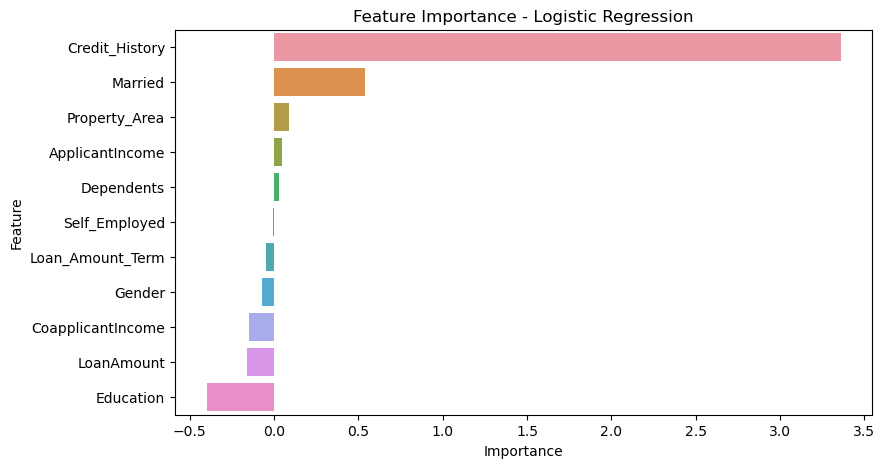

In [71]:
feature_importance = pd.DataFrame({
    'Feature': X.columns, 
    'Importance': model2.coef_[0]  # For logistic regression
})

# Sort by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Plotting the feature importance
plt.figure(figsize=(9, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance - Logistic Regression')
plt.show()